CUDA is available! DQN will use GPU acceleration.
Loaded 365 historical data points from CSV.
Running SIMPLIFIED trading simulation:
- 3 Actions: Hold, Buy 5%, Sell 1%
- Enhanced Reward Function:
  * ROI: 66% weight
  * Sharpe Ratio: 20% weight
  * Maximum Drawdown: 10% weight
  * Win Rate: 4% weight
  * Overtrading Penalty: Applied
- Observation Space: Price, volatility, position, cash

Running Actor-Critic simulations...

Running AC simulation with seed 1000 (1/5)
Setting PPO to use CPU instead of GPU for better performance with MLP policy


C:\Users\Kevin\AppData\Local\Temp\ipykernel_22988\3248281368.py:333: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


Optimal Policy Summary (First 10 and Last 5 steps):
Step 0: Price=$5137.08, Position=0.00, Cash=1.00 → Buy 5%
Step 1: Price=$5135.04, Position=0.10, Cash=0.90 → Buy 5%
Step 2: Price=$5132.99, Position=0.19, Cash=0.81 → Buy 5%
Step 3: Price=$5130.95, Position=0.27, Cash=0.73 → Buy 5%
Step 4: Price=$5078.65, Position=0.34, Cash=0.66 → Buy 5%
Step 5: Price=$5104.76, Position=0.41, Cash=0.59 → Buy 5%
Step 6: Price=$5157.36, Position=0.47, Cash=0.53 → Buy 5%
Step 7: Price=$5123.69, Position=0.52, Cash=0.48 → Buy 5%
Step 8: Price=$5121.77, Position=0.57, Cash=0.43 → Buy 5%
Step 9: Price=$5119.86, Position=0.61, Cash=0.39 → Buy 5%
...
Step 145: Price=$5427.13, Position=1.00, Cash=$0.00 → Buy 5%
Step 146: Price=$5399.22, Position=1.00, Cash=$0.00 → Buy 5%
Step 147: Price=$5459.10, Position=1.00, Cash=$0.00 → Buy 5%
Step 148: Price=$5460.58, Position=1.00, Cash=$0.00 → Buy 5%
Step 149: Price=$5462.06, Position=1.00, Cash=$0.00 → Buy 5%

Final Portfolio Value: $106160.88
Return on Investment: 6.

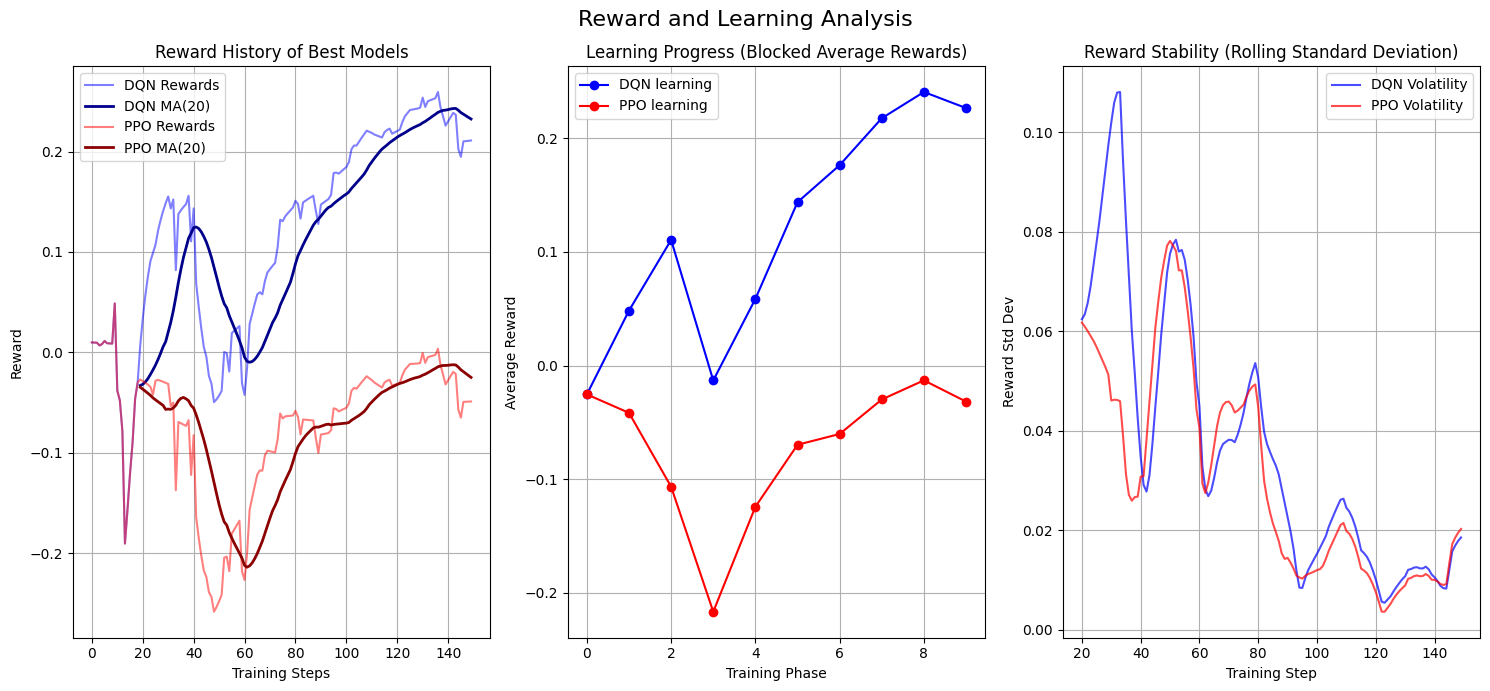

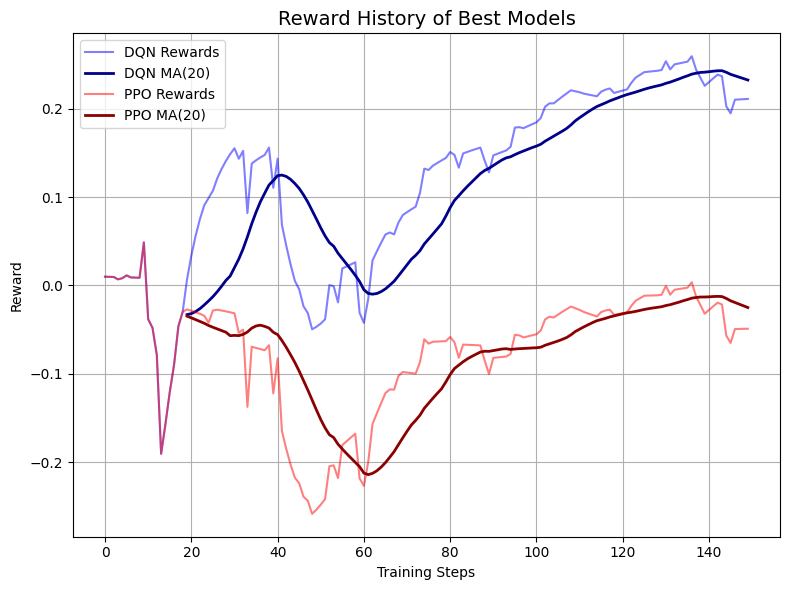

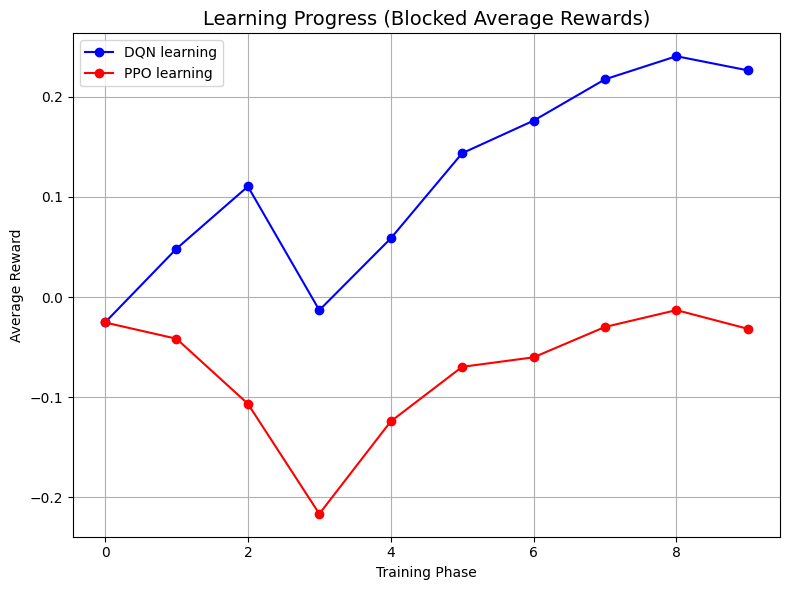

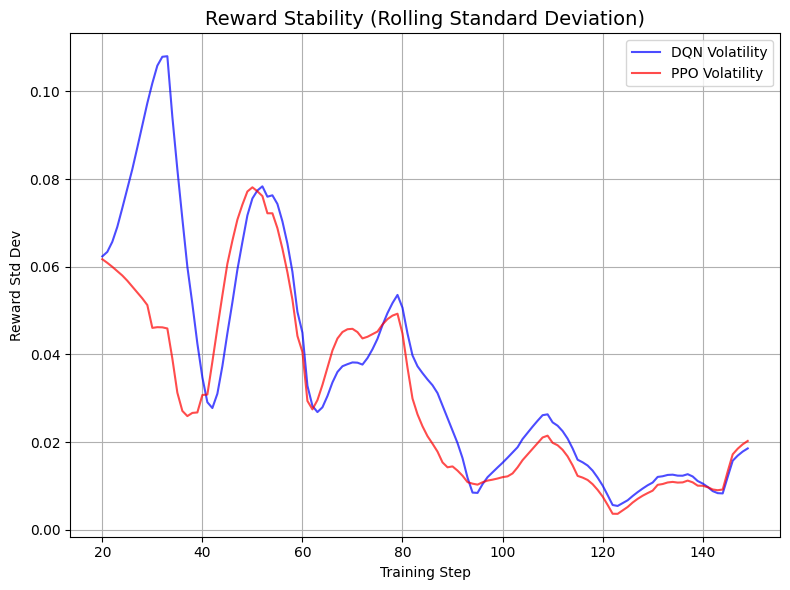


==== REWARD STATISTICS SUMMARY ====

DQN (Seed 1002):
  Average Reward: 0.1184
  Reward Std Dev: 0.1021
  Min Reward: -0.1905
  Max Reward: 0.2594
  Initial Avg Reward: 0.0352
  Final Avg Reward: 0.2304
  Learning Improvement: 0.1952

PPO (Seed 1000):
  Average Reward: -0.0719
  Reward Std Dev: 0.0684
  Min Reward: -0.2584
  Max Reward: 0.0488
  Initial Avg Reward: -0.0403
  Final Avg Reward: -0.0243
  Learning Improvement: 0.0160


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN , PPO
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from gymnasium import spaces

class TradingEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, historical_data, config=None):
        super(TradingEnv, self).__init__()
      
        self.config = {
            'initial_cash': 100000,
            'transaction_cost': 0.001,
            'buy_percentage': 0.1,
            'sell_percentage': 0.04,
            'render_mode': None
        }
        
        if config:
            self.config.update(config)

        self.historical_data = historical_data
        self.initial_cash = self.config['initial_cash']
        self.cash = self.initial_cash
        self.position = 0
        self.current_step = 0
        self.render_mode = self.config['render_mode']
        self.transaction_cost = self.config['transaction_cost']
        self.last_price = self.historical_data[0]['price']

        self.portfolio_history = [self.initial_cash]
        self.trades = []
        self.daily_returns = []
        self.purchase_prices = []  
        self.reward_history = []  

        
        self.action_counts = {0: 0, 1: 0, 2: 0}  # 0: hold, 1: buy, 2: sell

        # Add overtrading tracking
        self.total_trades = 0
        self.trading_actions = 0  

        # Simplified action space: 0=hold, 1=buy 5%, 2=sell 1%
        self.action_space = spaces.Discrete(3)

        
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

    def _get_obs(self):
        """Get the current observation."""
        
        current_idx = min(self.current_step, len(self.historical_data) - 1)
        current_data = self.historical_data[current_idx]

        price = current_data['price']
        norm_price = price / 1000.0  
        volatility = current_data['volatility']
        cash_norm = self.cash / self.initial_cash

        
        if price > 0:
            max_possible_position = self.initial_cash / price
            position_norm = min(self.position / max_possible_position, 1.0)
        else:
            position_norm = 0.0

        return np.array([
            norm_price,
            volatility,
            position_norm,
            cash_norm
        ], dtype=np.float32)

    def step(self, action):
        """Execute action and return new state, reward, done, and info."""
        
        self.action_counts[action] += 1

        if action in [1, 2]:  
            self.trading_actions += 1

        
        current_idx = min(self.current_step, len(self.historical_data) - 1)
        current_data = self.historical_data[current_idx]
        current_price = current_data['price']
        prev_portfolio = self.cash + self.position * current_price

        
        trade_info = {'type': None, 'profit': 0.0}

        
        if action == 1 and self.cash > 0:  
            cash_to_use = self.cash * self.config['buy_percentage']
            if cash_to_use > 0:
                units = cash_to_use / (current_price * (1 + self.transaction_cost))
                cost = units * current_price * (1 + self.transaction_cost)

                
                if cost <= self.cash:
                    self.cash -= cost
                    self.position += units

                   
                    self.purchase_prices.append((units, current_price))

                    trade_info['type'] = 'buy'
                    trade_info['units'] = units
                    trade_info['price'] = current_price
                    trade_info['cost'] = cost
                    self.trades.append(trade_info)
                    self.total_trades += 1

        elif action == 2 and self.position > 0:  # Sell 1%
            units_to_sell = self.position * self.config['sell_percentage']
            if units_to_sell > 0:
                sale_value = units_to_sell * current_price

                
                units_left_to_sell = units_to_sell
                cost_basis = 0

                
                remaining_purchases = []

                for units_batch, price_batch in self.purchase_prices:
                    if units_left_to_sell <= 0:
                        remaining_purchases.append((units_batch, price_batch))
                    elif units_batch <= units_left_to_sell:
                        
                        cost_basis += units_batch * price_batch
                        units_left_to_sell -= units_batch
                    else:
                        
                        cost_basis += units_left_to_sell * price_batch
                        remaining_purchases.append((units_batch - units_left_to_sell, price_batch))
                        units_left_to_sell = 0

                self.purchase_prices = remaining_purchases

                trade_info['type'] = 'sell'
                trade_info['units'] = units_to_sell
                trade_info['price'] = current_price
                trade_info['profit'] = sale_value - cost_basis
                revenue = sale_value * (1 - self.transaction_cost)
                self.cash += revenue
                self.position -= units_to_sell
                self.trades.append(trade_info)
                self.total_trades += 1

        
        self.current_step += 1
        terminated = self.current_step >= len(self.historical_data)
        truncated = False

        # Calculate new price and portfolio value with bounds checking
        if not terminated and self.current_step < len(self.historical_data):
            new_data = self.historical_data[self.current_step]
            new_price = new_data['price']
        else:
            new_price = current_price

        new_portfolio = self.cash + self.position * new_price
        self.portfolio_history.append(new_portfolio)

        # Calculate daily return
        daily_return = (new_portfolio - prev_portfolio) / prev_portfolio if prev_portfolio > 0 else 0
        self.daily_returns.append(daily_return)

        
        reward = self._calculate_financial_reward()
        self.reward_history.append(reward)  

        self.last_price = new_price
        obs = self._get_obs()
        info = {
            'portfolio_value': new_portfolio,
            'action': action
        }
        return obs, reward, terminated, truncated, info

    def _calculate_financial_reward(self):
        """Calculate reward based on ROI (0.66), Sharpe ratio (0.2), maximum drawdown (0.1), win rate (0.04), and overtrading penalty."""
        if len(self.portfolio_history) < 2:
            return 0.0

        # Calculate ROI (Return on Investment)
        current_portfolio = self.portfolio_history[-1]
        roi = (current_portfolio - self.initial_cash) / self.initial_cash
        roi_component = roi * 0.66  # Weight: 0.66

        # Calculate Sharpe ratio 
        sharpe_component = 0.0
        if len(self.daily_returns) >= 10:  
            returns_array = np.array(self.daily_returns)
            if np.std(returns_array) > 1e-6:  
                sharpe_ratio = np.mean(returns_array) / np.std(returns_array)
                
                normalized_sharpe = np.tanh(sharpe_ratio * 10) / 2 + 0.5  
                sharpe_component = normalized_sharpe * 0.2  

        # Calculate maximum drawdown
        max_drawdown = 0.0
        if len(self.portfolio_history) >= 3:
            peak = self.portfolio_history[0]
            max_drawdown_value = 0.0

            for value in self.portfolio_history:
                if value > peak:
                    peak = value
                if peak > 0:
                    drawdown = (peak - value) / peak
                    max_drawdown_value = max(max_drawdown_value, drawdown)

            max_drawdown = max_drawdown_value

        
        drawdown_component = -max_drawdown * 0.1  

        # Calculate win rate component 
        win_rate_component = 0.0
        if len(self.trades) > 0:
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            if len(sell_trades) >= 1:  
                winning_trades = [t for t in sell_trades if t['profit'] > 0]
                win_rate = len(winning_trades) / len(sell_trades)
                win_rate_component = win_rate * 0.04  
            else:
                
                if self.position > 0 and self.cash > 0:
                    win_rate_component = 0.01  

       
        overtrading_penalty = 0.0
        if self.current_step > 10:  
            
            trading_frequency = self.trading_actions / self.current_step

            
            optimal_frequency = 0.3  
            if trading_frequency > optimal_frequency:
                
                excess_trading = trading_frequency - optimal_frequency
                overtrading_penalty = -(excess_trading ** 2) * 0.5

            
            if trading_frequency < 0.05 and self.current_step > 50:  
                overtrading_penalty -= 0.01

            # Additional penalty for transaction costs
            total_transaction_cost = self.total_trades * self.transaction_cost * 0.1
            overtrading_penalty -= total_transaction_cost

        # Combine all components
        total_reward = roi_component + sharpe_component + drawdown_component + win_rate_component + overtrading_penalty

        # Clip reward to prevent extreme values
        return np.clip(total_reward, -1.0, 1.0)

    def reset(self, seed=None, options=None):
        """Reset the environment to initial state."""
        if seed is not None:
            np.random.seed(seed)
        self.cash = self.initial_cash
        self.position = 0
        self.current_step = 0
        self.last_price = self.historical_data[0]['price']
        self.purchase_prices = []
        self.portfolio_history = [self.initial_cash]
        self.trades = []
        self.daily_returns = []
        self.reward_history = []  

        
        self.action_counts = {0: 0, 1: 0, 2: 0}

        
        self.total_trades = 0
        self.trading_actions = 0

        return self._get_obs(), {}

    def render(self, mode="human"):
        """Render the current state of the environment."""
        current_idx = min(self.current_step, len(self.historical_data) - 1)
        current_data = self.historical_data[current_idx]
        price = current_data['price']
        portfolio_value = self.cash + self.position * price
        if mode == "human":
            print(f"Step: {self.current_step}, Price: {price:.2f}, Cash: {self.cash:.2f}, "
                  f"Position: {self.position:.2f}, Portfolio: {portfolio_value:.2f}")
        return

    def get_action_distribution(self):
        """Calculate the percentage distribution of actions taken."""
        total_actions = sum(self.action_counts.values())
        if total_actions == 0:
            return {"hold": 0.0, "buy": 0.0, "sell": 0.0}

        return {
            "hold": (self.action_counts[0] / total_actions) * 100,
            "buy": (self.action_counts[1] / total_actions) * 100,
            "sell": (self.action_counts[2] / total_actions) * 100
        }

def load_and_preprocess_data(csv_path):
    """Load and preprocess historical price data from CSV file."""
    df = pd.read_csv(csv_path)

    
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df = df[::-1]  
    
    numeric_cols = ['Price', 'Open', 'High', 'Low']
    for col in numeric_cols:
        df[col] = df[col].astype(str).str.replace(",", "").astype(float)

    
    if 'Change %' in df.columns:
        df.drop('Change %', axis=1, inplace=True)

    # Fill missing dates with interpolated values
    date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
    df = df.set_index('Date').reindex(date_range).reset_index()
    df.rename(columns={'index': 'Date'}, inplace=True)
    df.interpolate(method='linear', inplace=True)

    # Create historical data structure
    historical_data = []
    for _, row in df.iterrows():
        historical_data.append({
            'price': row['Price'],
            'volatility': 0.005  
        })

    print(f"Loaded {len(historical_data)} historical data points from CSV.")
    return df, historical_data

def run_trading_simulation(historical_data, config=None):
    """Run a trading simulation using the DQN agent with optimized parameters."""
    if config is None:
        config = {
            'initial_cash': 100000,
            'timesteps': 20000,  
            'evaluation_steps': 200,  
            'seed': 1073741824,
            'render_mode': None,  
            'device': 'auto'
        }

    env_config = {
        'initial_cash': config['initial_cash'],
        'render_mode': config['render_mode']
    }

    
    env = make_vec_env(
        lambda: TradingEnv(historical_data, env_config),
        n_envs=1,
        seed=config['seed']
    )

    
    model = DQN(
        "MlpPolicy",
        env,
        verbose=0,  
        learning_rate=1e-3,  
        gamma=0.95,  
        exploration_fraction=0.4,  
        exploration_initial_eps=1.0,
        exploration_final_eps=0.05,  
        target_update_interval=1000,
        buffer_size=100000,  
        learning_starts=2000,  
        batch_size=128,  
        seed=config['seed'],
        device=config['device']
    )
    model.learn(total_timesteps=config['timesteps'])

    
    state_history = []
    policy_log = []
    portfolio_values = []
    obs = env.reset()

    for _ in range(config['evaluation_steps']):
        action, _ = model.predict(obs, deterministic=True)  
        policy_log.append((obs[0], action))

        obs, _, done, info = env.step(action)
        state_history.append(obs[0])

        if 'portfolio_value' in info[0]:
            portfolio_values.append(info[0]['portfolio_value'])

        if done:
            break

   
    env_unwrapped = env.envs[0].unwrapped

    
    action_dist = env_unwrapped.get_action_distribution()
    reward_history = env_unwrapped.reward_history

    
    trades = env_unwrapped.trades
    portfolio_history = env_unwrapped.portfolio_history
    daily_returns = env_unwrapped.daily_returns

    
    final_portfolio = portfolio_history[-1]

   
    sell_trades = [t for t in trades if t['type'] == 'sell']
    winning_trades = [t for t in sell_trades if t['profit'] > 0]
    win_rate = len(winning_trades) / len(sell_trades) * 100 if sell_trades else 0

  
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)

  
    max_drawdown = calculate_max_drawdown(portfolio_history)

    metrics = {
        'win_rate': win_rate,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'action_distribution': action_dist,
        'reward_history': reward_history  
    }

    # Print results
    print_trading_results(policy_log, final_portfolio, config['initial_cash'], metrics)

    return np.array(state_history), final_portfolio, metrics

def run_trading_simulation_ac(historical_data, config=None):
    """Run a trading simulation using the PPO agent with optimized parameters."""
    if config is None:
        config = {
            'initial_cash': 100000,
            'timesteps': 20000,  
            'evaluation_steps': 200,  
            'seed': 1073741824,
            'render_mode': None,  
            'device': 'auto'
        }

    env_config = {
        'initial_cash': config['initial_cash'],
        'render_mode': config['render_mode']
    }

    
    env = make_vec_env(
        lambda: TradingEnv(historical_data, env_config),
        n_envs=1,
        seed=config['seed']
    )

    # Optimize device selection for PPO
    device = config['device']
    if device == 'cuda':
        print("Setting PPO to use CPU instead of GPU for better performance with MLP policy")
        device = 'cpu'

   
    model = PPO(
        "MlpPolicy",
        env,
        verbose=0, 
        learning_rate=3e-4,  
        gamma=0.95,  
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.02,  
        vf_coef=0.5,
        max_grad_norm=0.5,
        n_steps=4096,  
        batch_size=128,  
        n_epochs=10,
        seed=config['seed'],
        device=device
    )
    model.learn(total_timesteps=config['timesteps'])

  
    state_history = []
    policy_log = []
    portfolio_values = []
    obs = env.reset()

    for _ in range(config['evaluation_steps']):
        action, _ = model.predict(obs, deterministic=True)  
        policy_log.append((obs[0], action))

        obs, rewards, dones, info = env.step(action)
        state_history.append(obs[0])

        if 'portfolio_value' in info[0]:
            portfolio_values.append(info[0]['portfolio_value'])

        if dones:
            break

  
    env_unwrapped = env.envs[0].unwrapped

   
    action_dist = env_unwrapped.get_action_distribution()
    reward_history = env_unwrapped.reward_history

   
    trades = env_unwrapped.trades
    portfolio_history = env_unwrapped.portfolio_history
    daily_returns = env_unwrapped.daily_returns

   
    final_portfolio = portfolio_history[-1]

   
    sell_trades = [t for t in trades if t['type'] == 'sell']
    winning_trades = [t for t in sell_trades if t['profit'] > 0]
    win_rate = len(winning_trades) / len(sell_trades) * 100 if sell_trades else 0

  
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)

  
    max_drawdown = calculate_max_drawdown(portfolio_history)

    metrics = {
        'win_rate': win_rate,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'action_distribution': action_dist,
        'reward_history': reward_history  
    }

    
    print_trading_results(policy_log, final_portfolio, config['initial_cash'], metrics)

    return np.array(state_history), final_portfolio, metrics

def calculate_win_rate_fixed(trades):
    """Calculate win rate with better handling of edge cases."""
    if not trades:
        return 0.0

    sell_trades = [t for t in trades if t['type'] == 'sell']
    if not sell_trades:
      
        buy_trades = [t for t in trades if t['type'] == 'buy']
        if buy_trades:
            
            last_price = buy_trades[-1]['price']
            potential_winners = [t for t in buy_trades if last_price > t['price']]
            return (len(potential_winners) / len(buy_trades)) * 100
        return 0.0

    winning_trades = [t for t in sell_trades if t['profit'] > 0]
    return (len(winning_trades) / len(sell_trades)) * 100

def print_trading_results(policy_log, final_portfolio, initial_cash, metrics):
    """Print the results of the trading simulation with improved formatting."""
    print("Optimal Policy Summary (First 10 and Last 5 steps):")

   
    for i, (state, action) in enumerate(policy_log[:10]):
        norm_price, volatility, position, cash = state
        price = norm_price * 1000.0
        action_name = {0: "Hold", 1: "Buy 5%", 2: "Sell 1%"}[action[0]]
        print(f"Step {i}: Price=${price:.2f}, Position={position:.2f}, Cash={cash:.2f} → {action_name}")

    if len(policy_log) > 15:
        print("...")
        
        for i, (state, action) in enumerate(policy_log[-5:], len(policy_log)-5):
            norm_price, volatility, position, cash = state
            price = norm_price * 1000.0
            action_name = {0: "Hold", 1: "Buy 5%", 2: "Sell 1%"}[action[0]]
            print(f"Step {i}: Price=${price:.2f}, Position={position:.2f}, Cash=${cash:.2f} → {action_name}")

    print(f"\nFinal Portfolio Value: ${final_portfolio:.2f}")
    roi = ((final_portfolio / initial_cash) - 1) * 100
    print(f"Return on Investment: {roi:.2f}%")
    print(f"Win Rate: {metrics['win_rate']:.2f}%")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2f}%")

    # Print action distribution
    print(f"Action Distribution:")
    print(f"  Hold: {metrics['action_distribution']['hold']:.1f}%")
    print(f"  Buy: {metrics['action_distribution']['buy']:.1f}%")
    print(f"  Sell: {metrics['action_distribution']['sell']:.1f}%")

def calculate_optimal_gain_reward(historical_data, initial_cash):
    """Calculate the optimal gain possible with perfect future knowledge."""
    portfolio_values = []
    cash = initial_cash
    position = 0

    for i in range(len(historical_data) - 1):
        current_price = historical_data[i]['price']
        next_price = historical_data[i + 1]['price']

  
        if next_price > current_price and cash > 0:
        
            position = cash / current_price
            cash = 0
        elif next_price < current_price and position > 0:
           
            cash = position * current_price
            position = 0

        portfolio_value = cash + position * current_price
        portfolio_values.append(portfolio_value)

   
    final_price = historical_data[-1]['price']
    final_portfolio = cash + position * final_price
    portfolio_values.append(final_portfolio)

    return portfolio_values

def calculate_sharpe_ratio(returns):
    """Calculate annualized Sharpe ratio from a series of returns."""
    if len(returns) < 2 or np.std(returns) == 0:
        return 0.0
    
    # Annualize by multiplying to sqrt(252) - approximately 252 trading days in a year
    return (np.mean(returns) / np.std(returns)) * np.sqrt(252)

def calculate_max_drawdown(portfolio_values):
    """Calculate maximum drawdown from portfolio value history."""
    peak = portfolio_values[0]
    max_drawdown = 0.0

    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        max_drawdown = max(max_drawdown, drawdown)

    return max_drawdown * 100.0  # Convert to percentage

def run_multiple_seeds_with_model(historical_data, base_config, model_type="dqn", num_seeds=50):
    """Run trading simulations with multiple seeds and analyze results."""
    results = []

    for i in range(num_seeds):
        seed = 1000 + i  
        config = base_config.copy()
        config['seed'] = seed

        print(f"\nRunning {model_type.upper()} simulation with seed {seed} ({i+1}/{num_seeds})")

        if model_type.lower() == "dqn":
            state_history, final_portfolio, metrics = run_trading_simulation(
                historical_data, config
            )
        elif model_type.lower() in ["ac", "ppo"]:
            state_history, final_portfolio, metrics = run_trading_simulation_ac(
                historical_data, config
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        results.append({
            'model': model_type,
            'seed': seed,
            'final_portfolio': final_portfolio,
            'roi': ((final_portfolio / config['initial_cash']) - 1) * 100,
            'sharpe_ratio': metrics['sharpe_ratio'],
            'win_rate': metrics['win_rate'],
            'max_drawdown': metrics['max_drawdown'],
            'action_distribution': metrics['action_distribution']
        })

    return results

def compare_models(dqn_results, ac_results, initial_cash):
    """Compare performance between DQN and Actor-Critic models."""
   
    dqn_avg_portfolio = sum(r['final_portfolio'] for r in dqn_results) / len(dqn_results)
    dqn_avg_roi = sum(r['roi'] for r in dqn_results) / len(dqn_results)
    dqn_avg_sharpe = sum(r['sharpe_ratio'] for r in dqn_results) / len(dqn_results)
    dqn_avg_win_rate = sum(r['win_rate'] for r in dqn_results) / len(dqn_results)
    dqn_avg_max_dd = sum(r['max_drawdown'] for r in dqn_results) / len(dqn_results)

    ac_avg_portfolio = sum(r['final_portfolio'] for r in ac_results) / len(ac_results)
    ac_avg_roi = sum(r['roi'] for r in ac_results) / len(ac_results)
    ac_avg_sharpe = sum(r['sharpe_ratio'] for r in ac_results) / len(ac_results)
    ac_avg_win_rate = sum(r['win_rate'] for r in ac_results) / len(ac_results)
    ac_avg_max_dd = sum(r['max_drawdown'] for r in ac_results) / len(ac_results)

   
    dqn_hold = sum(r['action_distribution']['hold'] for r in dqn_results) / len(dqn_results)
    dqn_buy = sum(r['action_distribution']['buy'] for r in dqn_results) / len(dqn_results)
    dqn_sell = sum(r['action_distribution']['sell'] for r in dqn_results) / len(dqn_results)

    ac_hold = sum(r['action_distribution']['hold'] for r in ac_results) / len(ac_results)
    ac_buy = sum(r['action_distribution']['buy'] for r in ac_results) / len(ac_results)
    ac_sell = sum(r['action_distribution']['sell'] for r in ac_results) / len(ac_results)

    print("\n" + "="*50)
    print("       DQN vs ACTOR-CRITIC PERFORMANCE COMPARISON")
    print("="*50)
    print(f"Initial Investment: ${initial_cash:.2f}")
    print(f"Number of simulations per model: {len(dqn_results)}")

    print("\nDQN AVERAGE METRICS:")
    print(f"  Final Portfolio: ${dqn_avg_portfolio:.2f}")
    print(f"  Return on Investment: {dqn_avg_roi:.2f}%")
    print(f"  Sharpe Ratio: {dqn_avg_sharpe:.2f}")
    print(f"  Win Rate: {dqn_avg_win_rate:.2f}%")
    print(f"  Maximum Drawdown: {dqn_avg_max_dd:.2f}%")
    print(f"  Action Distribution:")
    print(f"    - Hold: {dqn_hold:.2f}%")
    print(f"    - Buy: {dqn_buy:.2f}%")
    print(f"    - Sell: {dqn_sell:.2f}%")

    print("\nACTOR-CRITIC AVERAGE METRICS:")
    print(f"  Final Portfolio: ${ac_avg_portfolio:.2f}")
    print(f"  Return on Investment: {ac_avg_roi:.2f}%")
    print(f"  Sharpe Ratio: {ac_avg_sharpe:.2f}")
    print(f"  Win Rate: {ac_avg_win_rate:.2f}%")
    print(f"  Maximum Drawdown: {ac_avg_max_dd:.2f}%")
    print(f"  Action Distribution:")
    print(f"    - Hold: {ac_hold:.2f}%")
    print(f"    - Buy: {ac_buy:.2f}%")
    print(f"    - Sell: {ac_sell:.2f}%")

   
    best_dqn = max(dqn_results, key=lambda x: x['roi'])
    best_ac = max(ac_results, key=lambda x: x['roi'])

    print("\nBEST DQN MODEL:")
    print(f"  Seed: {best_dqn['seed']}")
    print(f"  Final Portfolio: ${best_dqn['final_portfolio']:.2f}")
    print(f"  ROI: {best_dqn['roi']:.2f}%")

    print("\nBEST ACTOR-CRITIC MODEL:")
    print(f"  Seed: {best_ac['seed']}")
    print(f"  Final Portfolio: ${best_ac['final_portfolio']:.2f}")
    print(f"  ROI: {best_ac['roi']:.2f}%")

    return dqn_results, ac_results

def main():
    """Main function to run the trading simulation with simplified 3-action space."""
    
    base_config = {
        'csv_path': "S&P 500 Historical Data.csv",
        'initial_cash': 100000,
        'timesteps': 15000,
        'evaluation_steps': 150,
        'render_mode': None,
        'device': 'auto'
    }

  
    import torch
    if torch.cuda.is_available():
        print("CUDA is available! DQN will use GPU acceleration.")
        base_config['device'] = 'cuda'
    else:
        print("CUDA not available. Training will use CPU.")
        base_config['device'] = 'cpu'

   
    df, historical_data = load_and_preprocess_data(base_config['csv_path'])

    print("Running SIMPLIFIED trading simulation:")
    print("- 3 Actions: Hold, Buy 5%, Sell 1%")
    print("- Enhanced Reward Function:")
    print("  * ROI: 66% weight")
    print("  * Sharpe Ratio: 20% weight")
    print("  * Maximum Drawdown: 10% weight")
    print("  * Win Rate: 4% weight")
    print("  * Overtrading Penalty: Applied")
    print("- Observation Space: Price, volatility, position, cash")

 
    num_seeds = 5

    
    print("\n" + "="*50)
    print("Running Actor-Critic simulations...")
    ac_results = run_multiple_seeds_with_model(
        historical_data, base_config,
        model_type="ac", num_seeds=num_seeds
    )

  
    print("\n" + "="*50)
    print("Running DQN simulations...")
    dqn_results = run_multiple_seeds_with_model(
        historical_data, base_config,
        model_type="dqn", num_seeds=num_seeds
    )

   
    compare_models(dqn_results, ac_results, base_config['initial_cash'])

  
    all_results = dqn_results + ac_results
    best_result = max(all_results, key=lambda x: x['roi'])

    print(f"\nBest overall model: {best_result['model'].upper()} with seed {best_result['seed']} (ROI: {best_result['roi']:.2f}%)")

   
    best_dqn = max(dqn_results, key=lambda x: x['roi'])
    best_ac = max(ac_results, key=lambda x: x['roi'])

   
    print("\n" + "="*50)
    print(f"Detailed report for best DQN model (seed {best_dqn['seed']}, ROI: {best_dqn['roi']:.2f}%)")
    dqn_config = base_config.copy()
    dqn_config['seed'] = best_dqn['seed']
    print("\nRunning DQN with best seed for detailed analysis...")
    dqn_state_history, dqn_final_portfolio, dqn_metrics = run_trading_simulation(
        historical_data, dqn_config
    )
   
    best_dqn['reward_history'] = dqn_metrics.get('reward_history', [])

  
    print("\n" + "="*50)
    print(f"Detailed report for best PPO model (seed {best_ac['seed']}, ROI: {best_ac['roi']:.2f}%)")
    ac_config = base_config.copy()
    ac_config['seed'] = best_ac['seed']
    print("\nRunning PPO with best seed for detailed analysis...")
    ac_state_history, ac_final_portfolio, ac_metrics = run_trading_simulation_ac(
        historical_data, ac_config
    )
   
    best_ac['reward_history'] = ac_metrics.get('reward_history', [])

   
    plot_reward_and_learning(dqn_results, ac_results, best_dqn, best_ac)

def plot_reward_and_learning(dqn_results, ac_results, best_dqn, best_ac):
    """Plot reward history and learning progress for DQN and PPO models."""
   
    plt.figure(figsize=(15, 7))

  
    plt.subplot(1, 3, 1)
    if 'reward_history' in best_dqn and best_dqn['reward_history']:
        dqn_rewards = best_dqn['reward_history']
        plt.plot(np.arange(len(dqn_rewards)), dqn_rewards, color='blue', alpha=0.5, label=f'DQN Rewards')

        
        window = min(20, len(dqn_rewards) // 5)
        if window > 1:
            dqn_ma = np.convolve(dqn_rewards, np.ones(window)/window, mode='valid')
            plt.plot(np.arange(window-1, len(dqn_rewards)), dqn_ma, color='darkblue',
                    linewidth=2, label=f'DQN MA({window})')

    if 'reward_history' in best_ac and best_ac['reward_history']:
        ac_rewards = best_ac['reward_history']
        plt.plot(np.arange(len(ac_rewards)), ac_rewards, color='red', alpha=0.5, label=f'PPO Rewards')

       
        window = min(20, len(ac_rewards) // 5)
        if window > 1:
            ac_ma = np.convolve(ac_rewards, np.ones(window)/window, mode='valid')
            plt.plot(np.arange(window-1, len(ac_rewards)), ac_ma, color='darkred',
                    linewidth=2, label=f'PPO MA({window})')

    plt.title("Reward History of Best Models")
    plt.xlabel("Training Steps")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 3, 2)

  
    if 'reward_history' in best_dqn and len(best_dqn['reward_history']) > 10:
        dqn_rewards = best_dqn['reward_history']
        block_size = max(10, len(dqn_rewards) // 10)  
        dqn_blocks = []

        for i in range(0, len(dqn_rewards), block_size):
            block = dqn_rewards[i:i+block_size]
            if block:
                dqn_blocks.append(np.mean(block))

        plt.plot(np.arange(len(dqn_blocks)), dqn_blocks, 'o-', color='blue', label='DQN learning')

   
    if 'reward_history' in best_ac and len(best_ac['reward_history']) > 10:
        ac_rewards = best_ac['reward_history']
        block_size = max(10, len(ac_rewards) // 10)  
        ac_blocks = []

        for i in range(0, len(ac_rewards), block_size):
            block = ac_rewards[i:i+block_size]
            if block:
                ac_blocks.append(np.mean(block))

        plt.plot(np.arange(len(ac_blocks)), ac_blocks, 'o-', color='red', label='PPO learning')

    plt.title("Learning Progress (Blocked Average Rewards)")
    plt.xlabel("Training Phase")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)

   
    plt.subplot(1, 3, 3)

    if 'reward_history' in best_dqn and len(best_dqn['reward_history']) > 10:
        dqn_rewards = np.array(best_dqn['reward_history'])
        window = min(20, len(dqn_rewards) // 5)
        if window > 1:
            dqn_rolling_std = []
            for i in range(window, len(dqn_rewards)):
                dqn_rolling_std.append(np.std(dqn_rewards[i-window:i]))
            plt.plot(np.arange(window, len(dqn_rewards)), dqn_rolling_std, color='blue',
                    label='DQN Volatility', alpha=0.7)

    if 'reward_history' in best_ac and len(best_ac['reward_history']) > 10:
        ac_rewards = np.array(best_ac['reward_history'])
        window = min(20, len(ac_rewards) // 5)
        if window > 1:
            ac_rolling_std = []
            for i in range(window, len(ac_rewards)):
                ac_rolling_std.append(np.std(ac_rewards[i-window:i]))
            plt.plot(np.arange(window, len(ac_rewards)), ac_rolling_std, color='red',
                    label='PPO Volatility', alpha=0.7)

    plt.title("Reward Stability (Rolling Standard Deviation)")
    plt.xlabel("Training Step")
    plt.ylabel("Reward Std Dev")
    plt.legend()
    plt.grid(True)

   
    plt.suptitle("Reward and Learning Analysis", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Figure 1: Reward History
    plt.figure(figsize=(8, 6))
    if 'reward_history' in best_dqn and best_dqn['reward_history']:
        dqn_rewards = best_dqn['reward_history']
        plt.plot(np.arange(len(dqn_rewards)), dqn_rewards, color='blue', alpha=0.5, label=f'DQN Rewards')

        window = min(20, len(dqn_rewards) // 5)
        if window > 1:
            dqn_ma = np.convolve(dqn_rewards, np.ones(window)/window, mode='valid')
            plt.plot(np.arange(window-1, len(dqn_rewards)), dqn_ma, color='darkblue',
                    linewidth=2, label=f'DQN MA({window})')

    if 'reward_history' in best_ac and best_ac['reward_history']:
        ac_rewards = best_ac['reward_history']
        plt.plot(np.arange(len(ac_rewards)), ac_rewards, color='red', alpha=0.5, label=f'PPO Rewards')

        window = min(20, len(ac_rewards) // 5)
        if window > 1:
            ac_ma = np.convolve(ac_rewards, np.ones(window)/window, mode='valid')
            plt.plot(np.arange(window-1, len(ac_rewards)), ac_ma, color='darkred',
                    linewidth=2, label=f'PPO MA({window})')

    plt.title("Reward History of Best Models", fontsize=14)
    plt.xlabel("Training Steps")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Figure 2: Learning Progress
    plt.figure(figsize=(8, 6))
    if 'reward_history' in best_dqn and len(best_dqn['reward_history']) > 10:
        dqn_rewards = best_dqn['reward_history']
        block_size = max(10, len(dqn_rewards) // 10)
        dqn_blocks = []

        for i in range(0, len(dqn_rewards), block_size):
            block = dqn_rewards[i:i+block_size]
            if block:
                dqn_blocks.append(np.mean(block))

        plt.plot(np.arange(len(dqn_blocks)), dqn_blocks, 'o-', color='blue', label='DQN learning')

    if 'reward_history' in best_ac and len(best_ac['reward_history']) > 10:
        ac_rewards = best_ac['reward_history']
        block_size = max(10, len(ac_rewards) // 10)
        ac_blocks = []

        for i in range(0, len(ac_rewards), block_size):
            block = ac_rewards[i:i+block_size]
            if block:
                ac_blocks.append(np.mean(block))

        plt.plot(np.arange(len(ac_blocks)), ac_blocks, 'o-', color='red', label='PPO learning')

    plt.title("Learning Progress (Blocked Average Rewards)", fontsize=14)
    plt.xlabel("Training Phase")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Figure 3: Reward Stability
    plt.figure(figsize=(8, 6))
    if 'reward_history' in best_dqn and len(best_dqn['reward_history']) > 10:
        dqn_rewards = np.array(best_dqn['reward_history'])
        window = min(20, len(dqn_rewards) // 5)
        if window > 1:
            dqn_rolling_std = []
            for i in range(window, len(dqn_rewards)):
                dqn_rolling_std.append(np.std(dqn_rewards[i-window:i]))
            plt.plot(np.arange(window, len(dqn_rewards)), dqn_rolling_std, color='blue',
                    label='DQN Volatility', alpha=0.7)

    if 'reward_history' in best_ac and len(best_ac['reward_history']) > 10:
        ac_rewards = np.array(best_ac['reward_history'])
        window = min(20, len(ac_rewards) // 5)
        if window > 1:
            ac_rolling_std = []
            for i in range(window, len(ac_rewards)):
                ac_rolling_std.append(np.std(ac_rewards[i-window:i]))
            plt.plot(np.arange(window, len(ac_rewards)), ac_rolling_std, color='red',
                    label='PPO Volatility', alpha=0.7)

    plt.title("Reward Stability (Rolling Standard Deviation)", fontsize=14)
    plt.xlabel("Training Step")
    plt.ylabel("Reward Std Dev")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    print("\n==== REWARD STATISTICS SUMMARY ====")

    if 'reward_history' in best_dqn and best_dqn['reward_history']:
        dqn_rewards = np.array(best_dqn['reward_history'])
        print(f"\nDQN (Seed {best_dqn['seed']}):")
        print(f"  Average Reward: {np.mean(dqn_rewards):.4f}")
        print(f"  Reward Std Dev: {np.std(dqn_rewards):.4f}")
        print(f"  Min Reward: {np.min(dqn_rewards):.4f}")
        print(f"  Max Reward: {np.max(dqn_rewards):.4f}")
        if len(dqn_rewards) > 10:
            first_quarter = dqn_rewards[:len(dqn_rewards)//4]
            last_quarter = dqn_rewards[3*len(dqn_rewards)//4:]
            print(f"  Initial Avg Reward: {np.mean(first_quarter):.4f}")
            print(f"  Final Avg Reward: {np.mean(last_quarter):.4f}")
            print(f"  Learning Improvement: {np.mean(last_quarter) - np.mean(first_quarter):.4f}")

    if 'reward_history' in best_ac and best_ac['reward_history']:
        ac_rewards = np.array(best_ac['reward_history'])
        print(f"\nPPO (Seed {best_ac['seed']}):")
        print(f"  Average Reward: {np.mean(ac_rewards):.4f}")
        print(f"  Reward Std Dev: {np.std(ac_rewards):.4f}")
        print(f"  Min Reward: {np.min(ac_rewards):.4f}")
        print(f"  Max Reward: {np.max(ac_rewards):.4f}")
        if len(ac_rewards) > 10:
            first_quarter = ac_rewards[:len(ac_rewards)//4]
            last_quarter = ac_rewards[3*len(ac_rewards)//4:]
            print(f"  Initial Avg Reward: {np.mean(first_quarter):.4f}")
            print(f"  Final Avg Reward: {np.mean(last_quarter):.4f}")
            print(f"  Learning Improvement: {np.mean(last_quarter) - np.mean(first_quarter):.4f}")

if __name__ == "__main__":
    main()